<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Caso de estudio 1: Cambio de uso

Este caso de estudio es una adaptación del caso original desarrollado por Digital Earth Australia, que puede ser encontrado [aquí](https://github.com/csiro-easi/eocsi-hackathon-2022/blob/main/case-studies/Change_detection.ipynb).

El objetivo es detectar cambio de uso de suelo vinculado a la vegetación, ya sea un aumento o una disminución de la vegetación en el espacio, entre los años 2014 y 2022.

Las actividades claves son:
* Definir área de estudio, temporalidad, sensores y bandas a utilizar
* Limpiar los datos
* Calcular índices
* Realizar prueba de hipótesis
* Visualizar resultados

***

In [1]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True)

import sys
sys.path.append("../../dea-notebooks/Tools")
from dea_tools.plotting import display_map, rgb

/env/lib/python3.10/site-packages/dea_tools/plotting.py:38: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
dc = datacube.Datacube(app='caso_1') # https://opendatacube.readthedocs.io/en/latest/api/core-classes/datacube.html

# Definir área de estudio, temporalidad, sensores y bandas a utilizar

Nos centraremos en un sector de la cordillera de la costa de la región de los Ríos, colindando con la región de la Araucanía (-39.41, -72.96).
Debido a que nos enfocaremos en la vegetación, las bandas de interes serán roja e infrarroja para el cálculo de NDVI. También requerimos las bandas de calidad, para filtrar las nubes y otros artefactos.

Aprovecharemos la mejor resolución espacial que nos entrega Landsat, que es de 30x30 metros, y utilizaremos el siguiente sistema de referencia de coordenadas: "WGS84 UTM 19 Sur (EPSG: 32719)"

In [37]:
buffer = .1

query = {
    "product": "landsat8_c2l2_sr",
    "measurements" : ["red", "nir08", "qa_pixel"],
    "x": -72.9575 + np.array([buffer, -buffer]),
    "y": -39.4054 + np.array([buffer, -buffer]),
    "time": ("2014-01-01", "2022-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [4]:
display_map(x=query['x'], y=query['y'])

/env/lib/python3.10/site-packages/dea_tools/plotting.py:313: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj('EPSG:4326'), all_x,


In [38]:
ds = dc.load(**query)

***

# Limpiar los datos

Eliminaremos pixeles con nodata, nieve, nubes, cirrus, y sombras producidas por nubes desde la banda de calidad.

In [39]:
masking.describe_variable_flags(ds.qa_pixel)

,bits,values,description
snow,5,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
clear,6,"{'0': 'not_clear', '1': 'clear'}",NaN
cloud,3,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
water,7,"{'0': 'land_or_cloud', '1': 'water'}",NaN
cirrus,2,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
nodata,0,"{'0': False, '1': True}",NaN
qa_pixel,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{'1': 'Fill', '2': 'Dilated Cloud', '4': 'Cirr...",Level 2 pixel quality
cloud_shadow,4,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
dilated_cloud,1,"{'0': 'not_dilated', '1': 'dilated'}",NaN
cloud_confidence,"[8, 9]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN


In [40]:
quality_band = 'qa_pixel'
cloud_free_mask = (
    masking.make_mask(ds[quality_band], snow='high_confidence') + 
    masking.make_mask(ds[quality_band], cloud="high_confidence") +
    masking.make_mask(ds[quality_band], cirrus="high_confidence") +
    masking.make_mask(ds[quality_band], cloud_shadow="high_confidence") +
    masking.make_mask(ds[quality_band], nodata=True)
)

In [41]:
dsf = xr.where(cloud_free_mask, np.nan, ds)

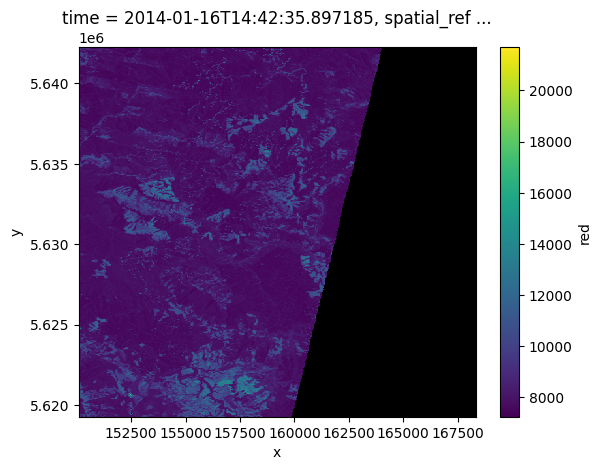

In [43]:
fig, ax = plt.subplots(1, 1)
dsf.red.isel(time=1).plot()
ax.set_facecolor("black")

In [44]:
dsf.update(dsf * 0.0000275 + -0.2)

<xarray.Dataset>
Dimensions:      (time: 356, y: 766, x: 608)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:36:32.640895 ... 2022-12...
  * y            (y) float64 5.642e+06 5.642e+06 ... 5.619e+06 5.619e+06
  * x            (x) float64 1.501e+05 1.501e+05 ... 1.683e+05 1.683e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 766, 608), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 766, 608), meta=np.ndarray>
    qa_pixel     (time, y, x) float64 dask.array<chunksize=(1, 766, 608), meta=np.ndarray>

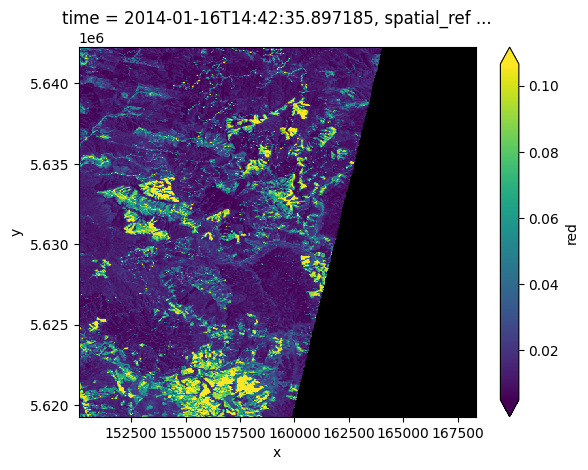

In [45]:
fig, ax = plt.subplots(1, 1)
dsf.red.isel(time=1).plot(robust=True)
ax.set_facecolor("black")

***
# Calcular índices

Calculamos el NDVI siguiendo la siguiente celda:

In [46]:
ndvi = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])
ndvi

<xarray.DataArray (time: 356, y: 766, x: 608)>
dask.array<truediv, shape=(356, 766, 608), dtype=float64, chunksize=(1, 766, 608), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:36:32.640895 ... 2022-12...
  * y            (y) float64 5.642e+06 5.642e+06 ... 5.619e+06 5.619e+06
  * x            (x) float64 1.501e+05 1.501e+05 ... 1.683e+05 1.683e+05
    spatial_ref  int32 32719

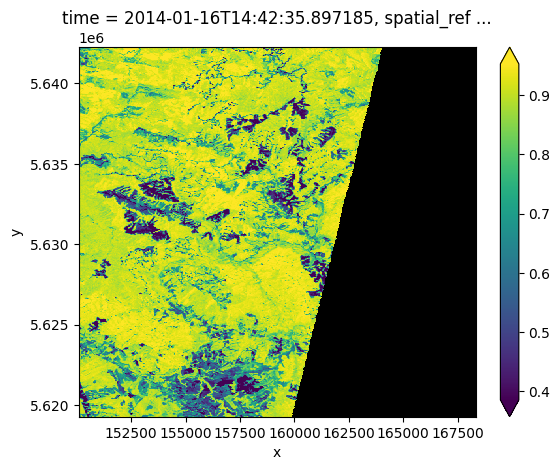

In [47]:
fig, ax = plt.subplots(1, 1)
ndvi.isel(time=1).plot(robust=True)
ax.set_facecolor("black")

# Realizar prueba de hipótesis

La idea es revisar si es que hay cambios significativos en el NDVI de la zona de estudio. Es un ejercicio simplificado, pero perfectamente aplicable. Podríamos contruir una hipótesis de la forma:

$$
\begin{aligned}
\text{hipótesis nula } (H_0) &: \text{no hubieron cambios,} \\
\text{hipótesis alternativa } (H_1) &: \text{hubieron algunos cambios.}
\end{aligned}
$$

## Selección de muestras
Solo requerimos datos para el año 2014 y 2022, por lo los filtraremos para realizar la prueba de hipótesis:

In [24]:
t0_date = np.datetime64('2014-12-31')
t1_date = np.datetime64('2022-12-31')
t0 = ndvi.time.dt.year == t0_date.astype(object).year
t1 = ndvi.time.dt.year == t1_date.astype(object).year

t0_sample = ndvi.sel(time = t0)
t1_sample = ndvi.sel(time = t1)

In [25]:
print(f"Observaciones de base: {len(t0_sample.time)}")
print(f"Observaciones posteriores: {len(t1_sample.time)}")

Observaciones de base: 38
Observaciones posteriores: 37


In [28]:
sample_lat_coords = ndvi.coords['y']
sample_lon_coords = ndvi.coords['x']

## Prueba estadística para verificar el cambio

Para buscar evidencia de que el NDVI promedio ha cambiado entre las dos muestras (ya sea positiva o negativamente), usamos la *prueba t* de Welch. Esto se usa para probar la hipótesis de que dos poblaciones tienen promedios iguales. En este caso, las poblaciones son el área de interés antes y después de las fechas de referencia, y el promedio que se prueba es el NDVI en ambos rangos. Se usa la *prueba t* de Welch (a diferencia de la prueba t de Student) porque las dos muestras en el estudio pueden no tener necesariamente varianzas iguales.

La prueba se ejecuta utilizando la biblioteca de estadísticas del paquete Scipy, que proporciona la función `ttest_ind` para ejecutar pruebas t. Establecer `equal_var=False` significa que la función ejecutará la *prueba t* de Welch. La función devuelve el *estadístico t* y el valor p para cada píxel después de probar la diferencia en el NDVI promedio. Estos se almacenan como `t_stat` y `p_val` dentro del conjunto de datos `t_test` para su uso en la siguiente sección

In [29]:
from scipy import stats

tstat, p_tstat = stats.ttest_ind(
    t1_sample.values,
    t0_sample.values,
    equal_var=False,
    nan_policy='omit',
)

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [30]:
# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {
        't_stat': (['y', 'x'], tstat),
        'p_val': (['y', 'x'], p_tstat)
    },
    coords={
        'x': (['x'], sample_lon_coords.values),
        'y': (['y'], sample_lat_coords.values)
    }, 
    attrs={
        'crs': 'EPSG:32719',
    })

t_test

<xarray.Dataset>
Dimensions:  (y: 766, x: 608)
Coordinates:
  * x        (x) float64 1.501e+05 1.501e+05 1.502e+05 ... 1.683e+05 1.683e+05
  * y        (y) float64 5.642e+06 5.642e+06 5.642e+06 ... 5.619e+06 5.619e+06
Data variables:
    t_stat   (y, x) float64 2.064 8.958 6.955 8.403 ... 0.3973 0.06495 -1.298
    p_val    (y, x) float64 0.04795 1.866e-10 3.24e-08 ... 0.6981 0.9491 0.2185
Attributes:
    crs:      EPSG:32719

# Visualizar resultados

De la prueba, nos interesan dos condiciones: si el cambio es significativo (rechazo de la hipótesis nula) y si el cambio fue positivo (forestación) o negativo (deforestación).

La hipótesis nula se puede rechazar si el *valor-p* (`p_val`) es menor que el nivel de significación elegido, que se establece como `sig_level = 0.05` (que es lo habitual) para este análisis. Si se rechaza la hipótesis nula, el píxel se clasificará como que ha sufrido un cambio significativo (si `p_val < 0.05`).

La dirección del cambio se puede deducir de la diferencia en el NDVI promedio de cada muestra, que se calcula como:

$$
\text{diferencia en la media} = \text{promedio(t0)} - \text{promedio(t1)}
$$

Esto significa que:

* si el NDVI promedio para un píxel determinado es más **alto** en `t1` en comparación con `t0`, entonces `diff_mean` para ese píxel será **positivo**.
* si el NDVI promedio para un píxel dado es más **bajo** en `t1` en comparación con `t0`, entonces `diff_mean` para ese píxel será **negativo**.

Al ejecutar las siguientes celdas, **el cambio positivo se muestra en verde (forestación) y el cambio negativo en rojo (deforestación).**

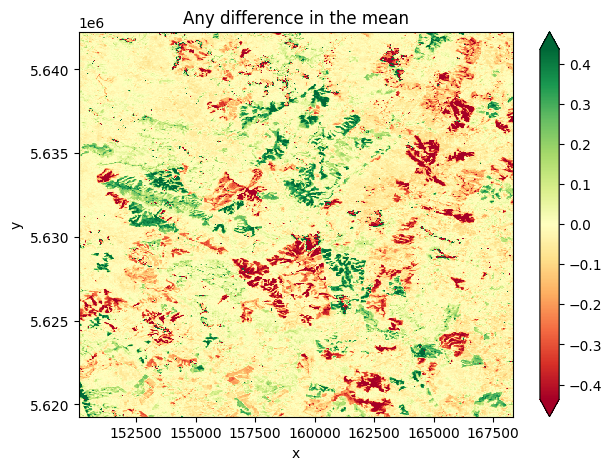

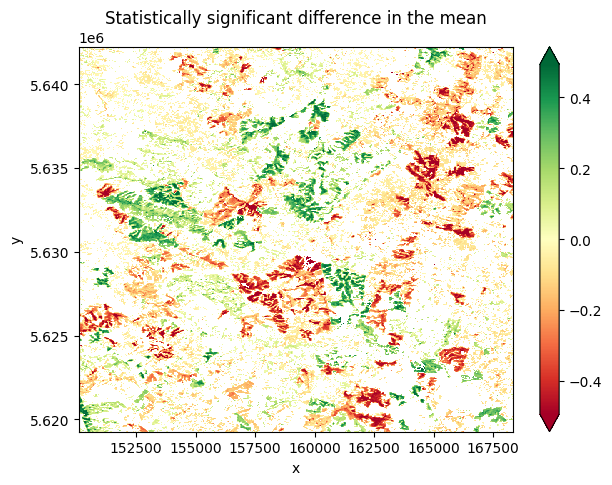

In [50]:
# Set the significance level
sig_level = 0.05

# Plot any difference in the mean
diff_mean = t1_sample.mean(dim=['time']) - t0_sample.mean(dim=['time'])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
diff_mean.plot(cmap='RdYlGn', robust=True)
ax.set_title('Any difference in the mean')
plt.show()

# Plot any difference in the mean classified as significant
sig_diff_mean = t1_sample.mean(dim=['time']).where(t_test.p_val < sig_level) - t0_sample.mean(dim=['time']).where(t_test.p_val < sig_level)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sig_diff_mean.plot(cmap='RdYlGn', robust=True)
ax.set_title('Statistically significant difference in the mean')
ax.set_facecolor("white")
plt.show()

***

# *Siguientes pasos* &#128062;

Para continuar con el tutorial pueden acceder a los notebooks del siguiente listado.

1. [Acceso](00_Acceso.ipynb)
2. [Cargar datos](01_Cargar_datos.ipynb)
3. [Limpieza](02_Limpieza.ipynb)
4. [Análisis básico](03_Análisis_básico.ipynb)
5. **Caso de estudio 1**
6. [Caso de estudio 2](05_Caso_de_estudio_2.ipynb)
7. [Trabajo final](05_Actividad_final.ipynb)

***